In [35]:
import glob
import calendar

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [10]:
obs_files = sorted(glob.glob("/g/data/zv2/agcd/v2-0-1/precip/total/r005/01month/agcd_v2-0-1_precip_total_r005_monthly_*.nc"))
hist_file = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/Amon/pr/gn/v20200529/pr_Amon_ACCESS-ESM1-5_historical_r6i1p1f1_gn_185001-201412.nc"
ssp_file = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r6i1p1f1/Amon/pr/gn/v20200908/pr_Amon_ACCESS-ESM1-5_ssp370_r6i1p1f1_gn_201501-210012.nc"

baseline_start = "1985-01-01"
baseline_end = "2014-12-31"
future_start = "2070-01-01"
future_end = "2099-12-31"

In [6]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Geraldton': (-28.8, 114.6),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

In [8]:
lat, lon = city_lat_lon['Brisbane']

In [15]:
ds_obs = xr.open_mfdataset(obs_files)
ds_obs = ds_obs.sel(lat=lat, lon=lon, method='nearest')
ds_obs = ds_obs.sel(time=slice(baseline_start, baseline_end))
ds_obs = ds_obs.compute()
ds_obs

<xarray.Dataset>
Dimensions:    (time: 360, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-16 ... 2014-12-16
    lat        float32 -27.5
    lon        float32 153.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds   (time, nv) float32 -27.52 -27.48 -27.52 ... -27.48 -27.52 -27.48
    lon_bnds   (time, nv) float32 153.0 153.0 153.0 153.0 ... 153.0 153.0 153.0
    time_bnds  (time, nv) datetime64[ns] 1985-01-01 1985-01-31 ... 2014-12-31
    precip     (time) float32 136.0 76.85 176.3 84.62 ... 8.035 108.4 128.7
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1900-01-01T00:00:00
    date_created:              2020-08-27T21:49:15.867624
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2023-05-21 22:51:24
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2023, ...
    history:

In [28]:
ds_hist = xr.open_dataset(hist_file)
ds_hist = ds_hist.sel(lat=lat, lon=lon, method='nearest')
ds_hist = ds_hist.sel(time=slice(baseline_start, baseline_end))
ds_hist['pr'] = (ds_hist['pr'] * 86400) * ds_hist['time'].dt.days_in_month
ds_hist['pr'].attrs['units'] = 'mm'
ds_hist = ds_hist.compute()
ds_hist

<xarray.Dataset>
Dimensions:    (time: 360, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-16T12:00:00 ... 2014-12-16T12:00:00
    lat        float64 -27.5
    lon        float64 153.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1985-01-01 1985-02-01 ... 2015-01-01
    lat_bnds   (bnds) float64 -28.12 -26.88
    lon_bnds   (bnds) float64 152.8 154.7
    pr         (time) float64 32.78 364.2 56.22 79.04 ... 11.94 40.83 86.97
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  58439.0
    creation_date:          2020-05-29T06:17:37Z
    ...                     ...
    variable_id:            pr
    variant_label:          r6i1p1f1
    version:                v20200529
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/3614ee4c-2b68-4b16-b45c-a6f98d54b7fe

In [29]:
ds_future = xr.open_dataset(ssp_file)
ds_future = ds_future.sel(lat=lat, lon=lon, method='nearest')
ds_future = ds_future.sel(time=slice(future_start, future_end))
ds_future['pr'] = (ds_future['pr'] * 86400) * ds_future['time'].dt.days_in_month
ds_future['pr'].attrs['units'] = 'mm'
ds_future = ds_future.compute()
ds_future

<xarray.Dataset>
Dimensions:    (time: 360, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2070-01-16T12:00:00 ... 2099-12-16T12:00:00
    lat        float64 -27.5
    lon        float64 153.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 2070-01-01 2070-02-01 ... 2100-01-01
    lat_bnds   (bnds) float64 -28.12 -26.88
    lon_bnds   (bnds) float64 152.8 154.7
    pr         (time) float64 169.3 46.55 65.15 54.99 ... 23.74 92.32 23.78
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP AerChemMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    creation_date:          2020-09-08T06:44:44Z
    ...                     ...
    variable_id:            pr
    variant_label:          r6i1p1f1
    version:                v20200908
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/4608377f-ced3-4624-98a5-3368e68a3e17

In [42]:
obs_monthly_mean = ds_obs['precip'].groupby('time.month').mean('time')
hist_monthly_mean = ds_hist['pr'].groupby('time.month').mean('time')
future_monthly_mean = ds_future['pr'].groupby('time.month').mean('time')

In [43]:
obs_annual = ds_obs['precip'].resample(time='Y').sum()
hist_annual = ds_hist['pr'].resample(time='Y').sum()
future_annual = ds_future['pr'].resample(time='Y').sum()

In [50]:
obs_annual_mean = obs_annual.mean('time')
hist_annual_mean = hist_annual.mean('time')
future_annual_mean = future_annual.mean('time')

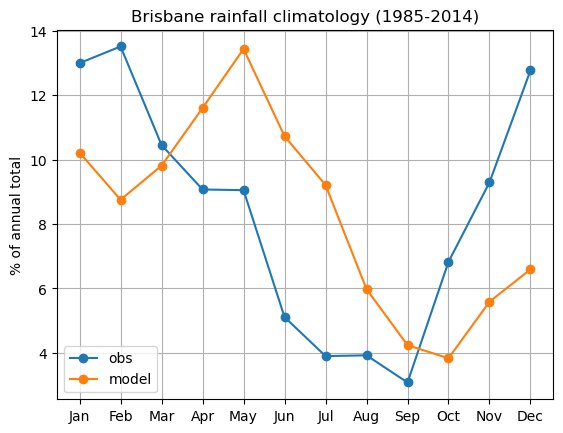

In [52]:
obs_monthly_annual_pct = (obs_monthly_mean.values / obs_annual_mean.values) * 100 
hist_monthly_annual_pct = (hist_monthly_mean.values / hist_annual_mean.values) * 100

xticks = np.arange(1, 13)
xtick_labels = [calendar.month_abbr[i] for i in xticks]

plt.plot(xticks, obs_monthly_annual_pct, label='obs', marker='o')
plt.plot(xticks, hist_monthly_annual_pct, label='model', marker='o')
plt.title('Brisbane rainfall climatology (1985-2014)')
plt.legend()
plt.ylabel('% of annual total')
plt.xticks(xticks, xtick_labels)
plt.grid()
plt.show()

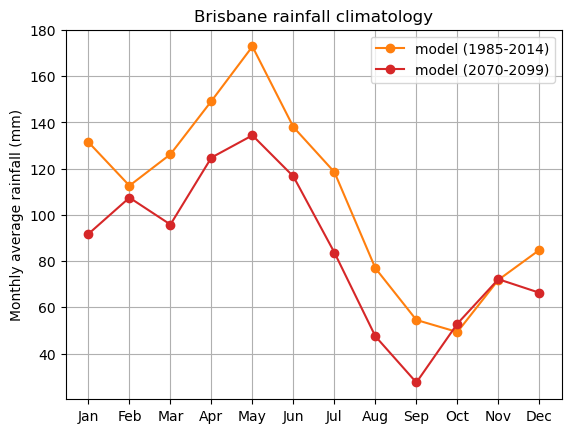

In [60]:
xticks = np.arange(1, 13)
xtick_labels = [calendar.month_abbr[i] for i in xticks]

plt.plot(xticks, hist_monthly_mean, label='model (1985-2014)', marker='o', color='tab:orange')
plt.plot(xticks, future_monthly_mean, label='model (2070-2099)', marker='o', color='tab:red')
plt.title('Brisbane rainfall climatology')
plt.legend()
plt.ylabel('Monthly average rainfall (mm)')
plt.xticks(xticks, xtick_labels)
plt.grid()
plt.show()

In [58]:
rainfall_change = future_annual_mean.values / hist_annual_mean.values
print(rainfall_change)

0.7936661116937781


In [63]:
monthly_adjustment_factors = future_monthly_mean / hist_monthly_mean

In [64]:
monthly_adjustment_factors

<xarray.DataArray 'pr' (month: 12)>
array([0.69814835, 0.95415428, 0.75912045, 0.83616988, 0.77756408,
       0.84509571, 0.70633011, 0.61702032, 0.50416772, 1.07319999,
       1.00393668, 0.78197441])
Coordinates:
    lat      float64 -27.5
    lon      float64 153.8
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
#delta_change = ( * mean_scalings_month) - obs_month_annual_pct
#    hist_month_only_changes = (hist_month_annual_pct * mean_scalings_month) - hist_month_annual_pct
#    ax2.bar(xticks, obs_month_only_changes, alpha=0.5, label='obs')
#    ax2.bar(xticks, hist_month_only_changes, alpha=0.5, label='model')
#    ax2.set_title('Mean scaling component')
#    ax2.legend()
#    ax2.set_xticks(xticks, xtick_labels)
#    ax2.grid()